# Détection de Fraude dans les Transactions Financières
## Azure Machine Learning + Power BI

**Objectif**: Entraîner un modèle de forêts aléatoires pour détecter les transactions frauduleuses et préparer les visualisations pour Power BI.

**Dataset**: 6M de transactions avec ~8k cas de fraude (classe très déséquilibrée)

---

## 1. Configuration et Installation des Dépendances

In [2]:
# Installation des packages nécessaires
!pip install azureml-sdk pandas numpy scikit-learn imbalanced-learn matplotlib seaborn mlflow joblib

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Azure ML
from azureml.core import Workspace, Dataset, Experiment, Run
from azureml.core.model import Model

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# MLflow pour le suivi d'expérience
import mlflow
import mlflow.sklearn

# Joblib pour la sérialisation
import joblib

print("✅ Bibliothèques importées avec succès")

✅ Bibliothèques importées avec succès


## 2. Connexion à Azure ML Workspace

In [4]:
# Connexion au workspace Azure ML
# Option 1: Depuis un fichier config.json
try:
    ws = Workspace.from_config()
    print(f"✅ Connecté au workspace: {ws.name}")
except:
    # Option 2: Connexion manuelle
    ws = Workspace(
        subscription_id='<VOTRE_SUBSCRIPTION_ID>',
        resource_group='<VOTRE_RESOURCE_GROUP>',
        workspace_name='<VOTRE_WORKSPACE_NAME>'
    )
    print(f"✅ Connecté au workspace: {ws.name}")

# Créer une expérience
experiment_name = 'fraud-detection-experiment'
experiment = Experiment(workspace=ws, name=experiment_name)
print(f"✅ Expérience créée: {experiment_name}")

✅ Connecté au workspace: creditfraudml
✅ Expérience créée: fraud-detection-experiment


## 3. Data Ingestion - Chargement des Données

In [6]:
# Option 1: Charger depuis Azure Blob Storage ou Dataset enregistré
# dataset = Dataset.get_by_name(ws, name='fraud_dataset')
# df = dataset.to_pandas_dataframe()

# Option 2: Charger depuis un fichier local ou un chemin
# Remplacez par le chemin de votre dataset

# df = pd.read_csv('fraud_dataset.csv')
from azureml.core import Workspace, Dataset, Datastore

datastore = Datastore.get(ws, datastore_name='workspaceblobstore')

dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, 'fraud_dataset.csv')]
)

df = dataset.to_pandas_dataframe()


print(f"✅ Données chargées: {df.shape[0]:,} lignes, {df.shape[1]} colonnes")
print(f"\n📊 Distribution des classes:")
print(df['isFraud'].value_counts())
print(f"\nTaux de fraude: {df['isFraud'].mean()*100:.4f}%")

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
✅ Données chargées: 6,362,620 lignes, 11 colonnes

📊 Distribution des classes:
isFraud
False    6354407
True        8213
Name: count, dtype: int64

Taux de fraude: 0.1291%


In [7]:
# Aperçu des données
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,True,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,False,False
1,True,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,False,False
2,True,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,True,False
3,True,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,True,False
4,True,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,False,False


In [8]:
# Informations sur le dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            object 
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         bool   
 10  isFlaggedFraud  bool   
dtypes: bool(2), float64(5), object(4)
memory usage: 449.0+ MB


## 4. Analyse Exploratoire des Données (EDA)

In [9]:
# Statistiques descriptives
df.describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


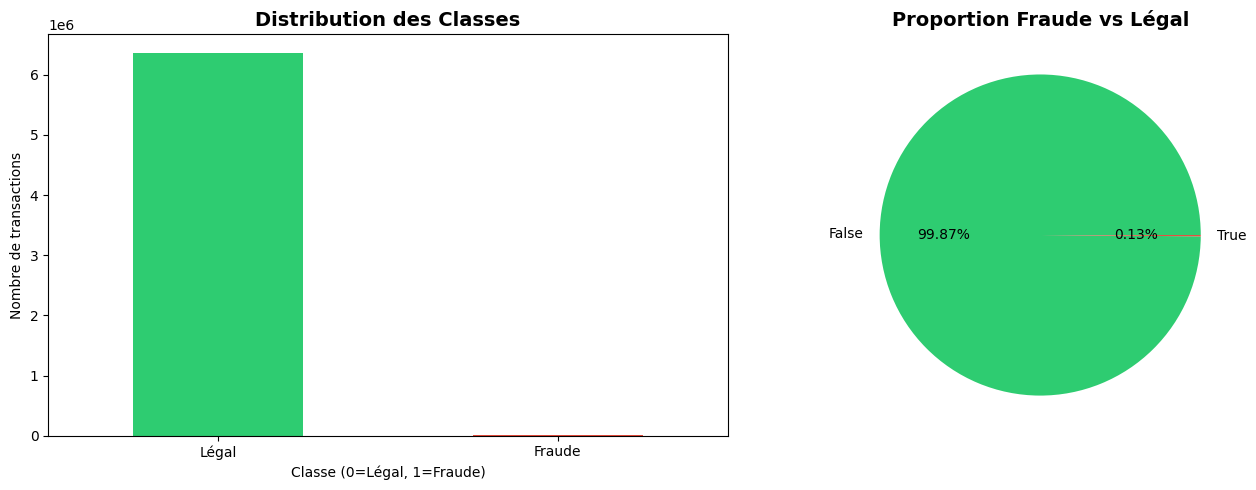

Déséquilibre des classes: 773.7:1


In [10]:
# Visualisation de la distribution des classes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique en barres
df['isFraud'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe (0=Légal, 1=Fraude)')
axes[0].set_ylabel('Nombre de transactions')
axes[0].set_xticklabels(['Légal', 'Fraude'], rotation=0)

# Graphique en camembert
colors = ['#2ecc71', '#e74c3c']
df['isFraud'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%', colors=colors)
axes[1].set_title('Proportion Fraude vs Légal', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Déséquilibre des classes: {df['isFraud'].value_counts()[0] / df['isFraud'].value_counts()[1]:.1f}:1")

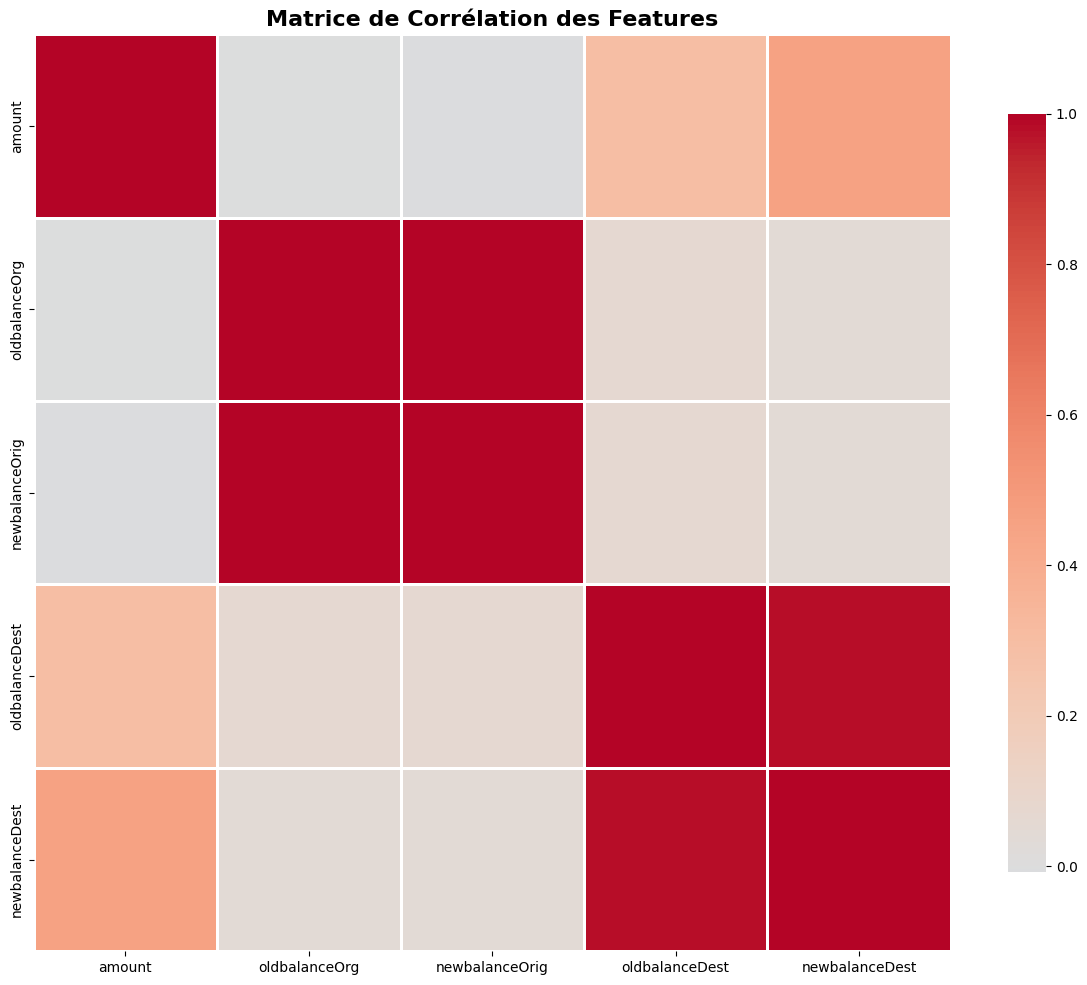

In [11]:
# Matrice de corrélation (pour les features numériques)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation des Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Analyse spécifique aux transactions financières
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution des montants (échelle log pour mieux voir)
axes[0, 0].hist(df['amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Montant de Transaction', fontsize=11)
axes[0, 0].set_ylabel('Fréquence', fontsize=11)
axes[0, 0].set_title('Distribution des Montants de Transaction', fontsize=13, fontweight='bold')
axes[0, 0].set_yscale('log')

# 2. Fraude par type de transaction
type_fraud = df.groupby([col for col in df.columns if col.startswith('type_')][0].replace({0: 'Non', 1: 'Oui'}))['isFraud'].value_counts().unstack(fill_value=0)
if 'type_PAYMENT' in df.columns:
    fraud_by_type = pd.DataFrame({
        'Type': [],
        'Fraude': [],
        'Légal': []
    })
    for col in [c for c in df.columns if c.startswith('type_')]:
        type_name = col.replace('type_', '')
        fraud_count = df[df[col] == 1]['isFraud'].sum()
        legit_count = len(df[df[col] == 1]) - fraud_count
        fraud_by_type = pd.concat([fraud_by_type, pd.DataFrame({
            'Type': [type_name],
            'Fraude': [fraud_count],
            'Légal': [legit_count]
        })], ignore_index=True)
    
    fraud_by_type.set_index('Type').plot(kind='bar', ax=axes[0, 1], color=['#e74c3c', '#2ecc71'])
    axes[0, 1].set_xlabel('Type de Transaction', fontsize=11)
    axes[0, 1].set_ylabel('Nombre de Transactions', fontsize=11)
    axes[0, 1].set_title('Fraude par Type de Transaction', fontsize=13, fontweight='bold')
    axes[0, 1].legend(['Fraude', 'Légal'])
    axes[0, 1].set_xticklabels(fraud_by_type['Type'], rotation=45, ha='right')

# 3. Montant moyen par statut de fraude
amount_by_fraud = df.groupby('isFraud')['amount'].mean()
axes[1, 0].bar(['Légal', 'Fraude'], amount_by_fraud.values, color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_ylabel('Montant Moyen', fontsize=11)
axes[1, 0].set_title('Montant Moyen par Statut', fontsize=13, fontweight='bold')
for i, v in enumerate(amount_by_fraud.values):
    axes[1, 0].text(i, v + v*0.02, f'{v:,.2f}', ha='center', va='bottom', fontweight='bold')

# 4. Distribution des fraudes vs légitimes (montants)
df[df['isFraud'] == 0]['amount'].hist(bins=50, alpha=0.6, label='Légal', color='green', ax=axes[1, 1])
df[df['isFraud'] == 1]['amount'].hist(bins=50, alpha=0.6, label='Fraude', color='red', ax=axes[1, 1])
axes[1, 1].set_xlabel('Montant', fontsize=11)
axes[1, 1].set_ylabel('Fréquence', fontsize=11)
axes[1, 1].set_title('Distribution des Montants: Fraude vs Légal', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.savefig('financial_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistiques clés
print("\n" + "="*60)
print("📊 STATISTIQUES CLÉS DES TRANSACTIONS")
print("="*60)
print(f"\nMontant moyen des transactions légales: {df[df['isFraud'] == 0]['amount'].mean():,.2f}")
print(f"Montant moyen des transactions frauduleuses: {df[df['isFraud'] == 1]['amount'].mean():,.2f}")
print(f"\nMontant médian des transactions légales: {df[df['isFraud'] == 0]['amount'].median():,.2f}")
print(f"Montant médian des transactions frauduleuses: {df[df['isFraud'] == 1]['amount'].median():,.2f}")

if 'type_TRANSFER' in df.columns:
    print(f"\nTaux de fraude pour TRANSFER: {df[df['type_TRANSFER'] == 1]['isFraud'].mean()*100:.2f}%")
if 'type_CASH_OUT' in df.columns:
    print(f"Taux de fraude pour CASH_OUT: {df[df['type_CASH_OUT'] == 1]['isFraud'].mean()*100:.2f}%")
if 'type_PAYMENT' in df.columns:
    print(f"Taux de fraude pour PAYMENT: {df[df['type_PAYMENT'] == 1]['isFraud'].mean()*100:.2f}%")

TypeError: replace expected at least 2 arguments, got 1

## 5. Préparation des Données (Data Processing)

In [13]:
# Gestion des valeurs manquantes
print("Valeurs manquantes par colonne:")
print(df.isnull().sum())

# Remplir ou supprimer les valeurs manquantes selon le besoin
# Exemple: df.fillna(df.median(), inplace=True)
df.dropna(inplace=True)

print(f"\n✅ Données après nettoyage: {df.shape[0]:,} lignes")

Valeurs manquantes par colonne:
step              6359912
type                    0
amount                  0
nameOrig                0
oldbalanceOrg           0
newbalanceOrig          0
nameDest                0
oldbalanceDest          0
newbalanceDest          0
isFraud                 0
isFlaggedFraud          0
dtype: int64

✅ Données après nettoyage: 2,708 lignes


In [14]:
# Feature Engineering spécifique au dataset de transactions financières

# 1. Encoder le type de transaction (PAYMENT, TRANSFER, CASH_OUT, etc.)
df = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=False)

# 2. Créer des features dérivées
# Variation de balance pour l'origine
df['balanceChange_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']

# Variation de balance pour la destination
df['balanceChange_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Ratio de la transaction par rapport au solde d'origine
df['amountToBalanceRatio_orig'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # +1 pour éviter division par 0

# Indicateur si le compte d'origine est vidé
df['isOriginEmpty'] = (df['newbalanceOrig'] == 0).astype(int)

# Indicateur si la destination avait un solde nul
df['isDestEmpty'] = (df['oldbalanceDest'] == 0).astype(int)

# Différence entre le montant et le changement de balance (détecte des anomalies)
df['errorBalanceOrig'] = df['balanceChange_orig'] - df['amount']
df['errorBalanceDest'] = df['balanceChange_dest'] - df['amount']

# 3. Supprimer les colonnes non nécessaires pour le modèle
# Les identifiants (nameOrig, nameDest) ne sont pas utiles pour la prédiction
columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']
df = df.drop(columns=columns_to_drop, errors='ignore')

print("✅ Feature Engineering complété")
print(f"Nombre total de features: {df.shape[1]}")
print(f"\nNouvelles features créées:")
print("  - balanceChange_orig: Variation du solde origine")
print("  - balanceChange_dest: Variation du solde destination")
print("  - amountToBalanceRatio_orig: Ratio montant/solde")
print("  - isOriginEmpty: Compte origine vidé")
print("  - isDestEmpty: Destination avec solde initial nul")
print("  - errorBalanceOrig/Dest: Détection d'anomalies de balance")
print(f"\nTypes de transactions encodés: {[col for col in df.columns if col.startswith('type_')]}")

✅ Feature Engineering complété
Nombre total de features: 19

Nouvelles features créées:
  - balanceChange_orig: Variation du solde origine
  - balanceChange_dest: Variation du solde destination
  - amountToBalanceRatio_orig: Ratio montant/solde
  - isOriginEmpty: Compte origine vidé
  - isDestEmpty: Destination avec solde initial nul
  - errorBalanceOrig/Dest: Détection d'anomalies de balance

Types de transactions encodés: ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [16]:
# Séparation des features et de la target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Sauvegarder les noms des colonnes pour plus tard
feature_names = X.columns.tolist()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nDistribution de y:\n{y.value_counts()}")
print(f"\nFeatures utilisées:")
for i, feat in enumerate(feature_names, 1):
    print(f"  {i:2d}. {feat}")

Features (X): (2708, 18)
Target (y): (2708,)

Distribution de y:
isFraud
False    2692
True       16
Name: count, dtype: int64

Features utilisées:
   1. step
   2. amount
   3. oldbalanceOrg
   4. newbalanceOrig
   5. oldbalanceDest
   6. newbalanceDest
   7. type_CASH_IN
   8. type_CASH_OUT
   9. type_DEBIT
  10. type_PAYMENT
  11. type_TRANSFER
  12. balanceChange_orig
  13. balanceChange_dest
  14. amountToBalanceRatio_orig
  15. isOriginEmpty
  16. isDestEmpty
  17. errorBalanceOrig
  18. errorBalanceDest


## 6. Split Train/Test

In [ ]:
# Division train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintenir la proportion des classes
)

print(f"Train set: {X_train.shape[0]:,} transactions")
print(f"Test set: {X_test.shape[0]:,} transactions")
print(f"\nDistribution train:")
print(y_train.value_counts())
print(f"\nDistribution test:")
print(y_test.value_counts())

## 7. Normalisation des Données

In [ ]:
# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Données normalisées")

## 8. Data Balancing - Gestion du Déséquilibre des Classes

Avec un ratio de ~750:1 (6M légitimes vs 8K fraudes), nous utilisons une approche hybride:
- **SMOTE** pour augmenter les cas de fraude
- **RandomUnderSampler** pour réduire les cas légitimes

In [ ]:
# Stratégie de rééquilibrage hybride
# SMOTE pour oversampling de la classe minoritaire
# Puis undersampling de la classe majoritaire

# Calculer les ratios souhaités
fraud_count = y_train.sum()
legit_count = len(y_train) - fraud_count

print(f"Avant rééquilibrage:")
print(f"  - Transactions légitimes: {legit_count:,}")
print(f"  - Transactions frauduleuses: {fraud_count:,}")
print(f"  - Ratio: {legit_count/fraud_count:.1f}:1")

# Pipeline de rééquilibrage
# D'abord SMOTE pour créer des exemples synthétiques de fraude
# Puis undersampling pour réduire les transactions légitimes
sampling_strategy_smote = 0.5  # Augmenter les fraudes à 50% des légitimes
sampling_strategy_under = 0.8  # Réduire pour avoir un ratio de 1:1.25

over = SMOTE(sampling_strategy=sampling_strategy_smote, random_state=42)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)

# Appliquer le pipeline
X_train_balanced, y_train_balanced = over.fit_resample(X_train_scaled, y_train)
X_train_balanced, y_train_balanced = under.fit_resample(X_train_balanced, y_train_balanced)

print(f"\nAprès rééquilibrage:")
print(f"  - Total: {len(y_train_balanced):,} transactions")
print(f"  - Distribution:")
print(pd.Series(y_train_balanced).value_counts())
print(f"  - Nouveau ratio: {pd.Series(y_train_balanced).value_counts()[0] / pd.Series(y_train_balanced).value_counts()[1]:.2f}:1")
print("\n✅ Données rééquilibrées avec succès")

## 9. Model Training - Entraînement du Modèle Random Forest

In [ ]:
# Démarrer le run MLflow
run = experiment.start_logging()
mlflow.sklearn.autolog()

print("🚀 Démarrage de l'entraînement du modèle Random Forest...")
print("="*60)

# Configuration du modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,          # Nombre d'arbres
    max_depth=20,              # Profondeur maximale
    min_samples_split=10,      # Minimum d'échantillons pour split
    min_samples_leaf=5,        # Minimum d'échantillons par feuille
    max_features='sqrt',       # Nombre de features à considérer
    random_state=42,
    n_jobs=-1,                 # Utiliser tous les CPU
    verbose=1,
    class_weight='balanced'    # Poids automatique des classes
)

# Entraînement
start_time = datetime.now()
rf_model.fit(X_train_balanced, y_train_balanced)
training_time = (datetime.now() - start_time).total_seconds()

print(f"\n✅ Entraînement terminé en {training_time:.2f} secondes")

# Log des hyperparamètres
run.log('n_estimators', 100)
run.log('max_depth', 20)
run.log('training_time_seconds', training_time)
run.log('training_samples', len(y_train_balanced))

## 10. Évaluation du Modèle

In [ ]:
# Prédictions sur le test set
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Métriques de performance
accuracy = rf_model.score(X_test_scaled, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*60)
print("📊 RÉSULTATS DU MODÈLE")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("="*60)

# Log des métriques dans Azure ML
run.log('accuracy', accuracy)
run.log('precision', precision)
run.log('recall', recall)
run.log('f1_score', f1)
run.log('roc_auc', roc_auc)

In [ ]:
# Rapport de classification détaillé
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Légal', 'Fraude']))

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Légal', 'Fraude'], 
            yticklabels=['Légal', 'Fraude'])
plt.title('Matrice de Confusion', fontsize=16, fontweight='bold')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
run.log_image('confusion_matrix', plot=plt)
plt.show()

print(f"\nVrais Négatifs (TN): {cm[0, 0]:,}")
print(f"Faux Positifs (FP): {cm[0, 1]:,}")
print(f"Faux Négatifs (FN): {cm[1, 0]:,}")
print(f"Vrais Positifs (TP): {cm[1, 1]:,}")

In [ ]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbe ROC - Détection de Fraude', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
run.log_image('roc_curve', plot=plt)
plt.show()

In [ ]:
# Courbe Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Courbe Precision-Recall', fontsize=16, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
run.log_image('precision_recall_curve', plot=plt)
plt.show()

## 11. Feature Importance - Importance des Variables

In [ ]:
# Extraire l'importance des features
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features les plus importantes
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title(f'Top {top_n} Features les Plus Importantes', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
run.log_image('feature_importance', plot=plt)
plt.show()

# Afficher le dataframe
print("\n📊 Top 10 Features:")
print(feature_importance.head(10))

## 12. Sauvegarde du Modèle

In [ ]:
# Sauvegarder le modèle et le scaler localement
model_filename = 'fraud_detection_rf_model.pkl'
scaler_filename = 'scaler.pkl'

joblib.dump(rf_model, model_filename)
joblib.dump(scaler, scaler_filename)

print(f"✅ Modèle sauvegardé: {model_filename}")
print(f"✅ Scaler sauvegardé: {scaler_filename}")

In [ ]:
# Enregistrer le modèle dans Azure ML
run.upload_file(name='outputs/' + model_filename, path_or_stream=model_filename)
run.upload_file(name='outputs/' + scaler_filename, path_or_stream=scaler_filename)

# Enregistrer comme modèle Azure ML
model = run.register_model(
    model_name='fraud-detection-rf',
    model_path='outputs/' + model_filename,
    description='Random Forest model for fraud detection',
    tags={
        'algorithm': 'RandomForest',
        'framework': 'scikit-learn',
        'accuracy': f'{accuracy:.4f}',
        'f1_score': f'{f1:.4f}',
        'roc_auc': f'{roc_auc:.4f}'
    }
)

print(f"✅ Modèle enregistré dans Azure ML: {model.name}, Version: {model.version}")

In [ ]:
# Terminer le run
run.complete()
print("✅ Expérience Azure ML terminée")

## 13. Préparation des Données pour Power BI

In [ ]:
# Créer un DataFrame avec les prédictions pour Power BI
results_df = X_test.copy()
results_df['actual_fraud'] = y_test.values
results_df['predicted_fraud'] = y_pred
results_df['fraud_probability'] = y_pred_proba

# Catégoriser les prédictions
results_df['prediction_category'] = results_df['fraud_probability'].apply(
    lambda x: 'Haute Suspicion' if x >= 0.8 else 
              ('Suspicion Moyenne' if x >= 0.5 else 'Faible Suspicion')
)

# Identifier les erreurs du modèle
results_df['prediction_result'] = 'Correct'
results_df.loc[(results_df['actual_fraud'] == 1) & (results_df['predicted_fraud'] == 0), 'prediction_result'] = 'Faux Négatif'
results_df.loc[(results_df['actual_fraud'] == 0) & (results_df['predicted_fraud'] == 1), 'prediction_result'] = 'Faux Positif'

print(f"✅ DataFrame de résultats créé: {results_df.shape}")
results_df.head()

In [ ]:
# Créer un résumé des métriques pour Power BI
metrics_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Value': [accuracy, precision, recall, f1, roc_auc]
})

print("\n📊 Résumé des Métriques:")
print(metrics_summary)

In [ ]:
# Créer des statistiques par catégorie de prédiction
category_stats = results_df.groupby('prediction_category').agg({
    'fraud_probability': ['count', 'mean', 'min', 'max'],
    'actual_fraud': 'sum'
}).round(4)
category_stats.columns = ['Count', 'Avg_Probability', 'Min_Probability', 'Max_Probability', 'Actual_Frauds']
category_stats = category_stats.reset_index()

print("\n📊 Statistiques par Catégorie:")
print(category_stats)

In [ ]:
# Analyse des transactions suspectes (probabilité > 0.8)
suspicious_transactions = results_df[results_df['fraud_probability'] > 0.8].copy()
suspicious_transactions = suspicious_transactions.sort_values('fraud_probability', ascending=False)

print(f"\n🚨 Transactions Hautement Suspectes: {len(suspicious_transactions):,}")
print(f"   - Vraies fraudes détectées: {suspicious_transactions['actual_fraud'].sum():,}")
print(f"   - Taux de précision: {suspicious_transactions['actual_fraud'].mean()*100:.2f}%")

suspicious_transactions.head(10)

## 14. Export des Données pour Power BI

In [ ]:
# Export vers CSV pour Power BI
results_df.to_csv('fraud_predictions_powerbi.csv', index=False)
metrics_summary.to_csv('model_metrics_powerbi.csv', index=False)
category_stats.to_csv('category_statistics_powerbi.csv', index=False)
suspicious_transactions.to_csv('suspicious_transactions_powerbi.csv', index=False)
feature_importance.to_csv('feature_importance_powerbi.csv', index=False)

print("✅ Fichiers exportés pour Power BI:")
print("   - fraud_predictions_powerbi.csv")
print("   - model_metrics_powerbi.csv")
print("   - category_statistics_powerbi.csv")
print("   - suspicious_transactions_powerbi.csv")
print("   - feature_importance_powerbi.csv")

## 15. Guide d'Intégration Power BI

In [ ]:
print("""
╔════════════════════════════════════════════════════════════════════╗
║           GUIDE D'INTÉGRATION POWER BI                             ║
╚════════════════════════════════════════════════════════════════════╝

📊 FICHIERS EXPORTÉS POUR POWER BI:
   ✓ fraud_predictions_powerbi.csv - Toutes les prédictions
   ✓ model_metrics_powerbi.csv - Métriques du modèle
   ✓ category_statistics_powerbi.csv - Stats par catégorie
   ✓ suspicious_transactions_powerbi.csv - Transactions suspectes
   ✓ feature_importance_powerbi.csv - Importance des variables

🎯 VISUALISATIONS RECOMMANDÉES DANS POWER BI:

1. DASHBOARD PRINCIPAL:
   • Carte de KPI: Nombre total de fraudes détectées
   • Carte de KPI: Taux de précision du modèle
   • Carte de KPI: F1-Score
   • Graphique en anneau: Répartition Légitimes vs Fraudes

2. ANALYSE DES TRANSACTIONS SUSPECTES:
   • Tableau: Top 100 transactions les plus suspectes
   • Graphique en barres: Nombre de transactions par catégorie de suspicion
   • Graphique linéaire: Évolution temporelle des fraudes (si date disponible)

3. PERFORMANCE DU MODÈLE:
   • Matrice de confusion (visuel personnalisé)
   • Graphique en colonnes: Métriques du modèle
   • Courbe ROC (si possible avec visuel personnalisé)

4. ANALYSE DES FEATURES:
   • Graphique en barres horizontales: Top 20 features importantes
   • Graphique de dispersion: Relation entre features et fraude

5. FILTRES INTERACTIFS:
   • Filtre par catégorie de prédiction
   • Filtre par résultat de prédiction (Correct, FP, FN)
   • Filtre par probabilité de fraude (seuils ajustables)

💡 ÉTAPES D'IMPORT DANS POWER BI:
   1. Ouvrir Power BI Desktop
   2. Obtenir des données > Fichier CSV
   3. Sélectionner les fichiers CSV exportés
   4. Transformer les données si nécessaire (Power Query)
   5. Créer les relations entre les tables
   6. Construire vos visualisations
   7. Publier vers Power BI Service pour partage

════════════════════════════════════════════════════════════════════
""")

## 16. Résumé Final

In [ ]:
print("""
╔════════════════════════════════════════════════════════════════════╗
║                    RÉSUMÉ DU PROJET                                ║
╚════════════════════════════════════════════════════════════════════╝

✅ ÉTAPES COMPLÉTÉES:
   1. ✓ Data Ingestion - Chargement de 6M de transactions
   2. ✓ Data Processing - Nettoyage et feature engineering
   3. ✓ Data Balancing - Rééquilibrage SMOTE + UnderSampling
   4. ✓ Model Training - Random Forest avec 100 arbres
   5. ✓ Experiment Tracking - Enregistrement dans Azure ML
   6. ✓ Model Evaluation - Métriques et visualisations
   7. ✓ Model Deployment - Sauvegarde et enregistrement Azure
   8. ✓ Power BI Export - Fichiers CSV prêts pour l'import

🎉 PROJET COMPLÉTÉ AVEC SUCCÈS! 🎉
════════════════════════════════════════════════════════════════════
""")